In [11]:
import numpy as np
from numpy.linalg import norm
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm

data = scipy.io.loadmat('./problem_data_files/LEO_DATA_Apparent_3Days.mat')['LEO_DATA_Apparent']
data2 = scipy.io.loadmat('./problem_data_files/LEO_DATA_Apparent_Days4-6.mat')['LEO_DATA_Apparent']
data2[:,1] += 3*86400

all_data = np.vstack([data,data2])
data = data[np.where(data[:,1] < 86400)]

data_s1 = data[np.where(data[:,0] == 1)]
data_s2 = data[np.where(data[:,0] == 2)]
data_s3 = data[np.where(data[:,0] == 3)]

pd_data = pd.DataFrame(data,columns=['id','t','r','rdot'])
# t_evals = pd_data['t'].values
t_evals = all_data[:,1]

from constants import *
from force_models import dynamics, accelerations
from coordinates import eci2ecef, ecef_eci
from observations import range_and_rate
from plotting import plot_eci, get_and_rescale


# from EKF_funcs import F,A,G,H,Q, EKF, residuals, propagate_to_delivery, Rot_BF2ECI, Rot_ECI2BF, plot_covariances

# Propagate given initial state and compute prefit residuals


In [110]:
# t_eval = t_evals + init_epoch_s
t_eval = np.arange(0,100*60,10) + init_epoch_s

orbit = scipy.integrate.solve_ivp(
    lambda t,s: dynamics(t,s,[1,'cannonball','cannonball',1,1]),
    t_span = [t_eval[0], t_eval[-1]],
    t_eval = t_eval,
    y0 = s_i,
    rtol=1e-10,
    atol=1e-12
)

In [44]:
def plot_eci(soln):
    # Your solution data: soln.y[0], soln.y[1], soln.y[2], and soln.t
    soln_y0 = soln.y[0]
    soln_y1 = soln.y[1]
    soln_y2 = soln.y[2]
    soln_t = soln.t - min(soln.t)

    indices = np.arange(0, len(soln_t), 15)

    arrows = [accelerations(t,s,return_extras=True) for t,s in zip(soln.t[indices], soln.y.T[indices])]

    grav = get_and_rescale(0, arrows)
    drag = get_and_rescale(1, arrows)
    srp = get_and_rescale(2, arrows)
    sungrav = get_and_rescale(3, arrows)
    moongrav = get_and_rescale(4, arrows)
    sun = get_and_rescale(5, arrows)
    moon = get_and_rescale(6, arrows)

    perturbs = [drag,srp,sungrav,moongrav]
    colors = ['tab:blue','tab:red','tab:orange','tab:grey']

    vector_scale = 1e6
    scaler = 0.3

    # Scale soln.t from 0 to 1
    scaled_t = (soln_t - np.min(soln_t)) / (np.max(soln_t) - np.min(soln_t))

    # Create a 1x3 grid of subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    fig.set_dpi(150)

    for ax in axs:
        circle = matplotlib.patches.Circle((0, 0), Rearth, color='blue', alpha=0.2)
        ax.add_artist(circle)

    # Create scatter plots for each pair of soln_y0, soln_y1, and soln_y2
    sc0 = axs[0].scatter(soln_y0, soln_y1, c=scaled_t, cmap='plasma',s=2)
    for i in range(len(perturbs)):
        axs[0].quiver(soln_y0[indices], soln_y1[indices], perturbs[i][:,0], perturbs[i][:,1], angles='xy', scale_units='xy', scale=1/vector_scale, color=colors[i])#plt.cm.plasma(scaled_t[indices]))
    axs[0].quiver(np.zeros_like(indices),np.zeros_like(indices),sun[:,0],sun[:,1], angles='xy', scale_units='xy', scale=scaler/vector_scale)
    axs[0].quiver(np.zeros_like(indices),np.zeros_like(indices),moon[:,0],moon[:,1], angles='xy', scale_units='xy', scale=scaler/vector_scale, color='grey')
    axs[0].set_xlabel("x [m]")
    axs[0].set_ylabel("y [m]")
    axs[0].set_aspect('equal')
    axs[0].set_xlim([-8e6,8e6])
    axs[0].set_ylim([-8e6,8e6])

    sc1 = axs[1].scatter(soln_y0, soln_y2, c=scaled_t, cmap='plasma',s=2)
    for i in range(4):
        axs[1].quiver(soln_y0[indices], soln_y2[indices], perturbs[i][:,0], perturbs[i][:,2], angles='xy', scale_units='xy', scale=1/vector_scale, color=colors[i])#plt.cm.plasma(scaled_t[indices]))
    axs[1].quiver(np.zeros_like(indices),np.zeros_like(indices),sun[:,0],sun[:,2], angles='xy', scale_units='xy', scale=scaler/vector_scale)
    axs[1].quiver(np.zeros_like(indices),np.zeros_like(indices),moon[:,0],moon[:,2], angles='xy', scale_units='xy', scale=scaler/vector_scale, color='grey')
    axs[1].set_xlabel("x [m]")
    axs[1].set_ylabel("z [m]")
    axs[1].set_aspect('equal')
    axs[1].set_xlim([-8e6,8e6])
    axs[1].set_ylim([-8e6,8e6])

    sc2 = axs[2].scatter(soln_y1, soln_y2, c=scaled_t, cmap='plasma',s=2)
    for i in range(4):
        axs[2].quiver(soln_y1[indices], soln_y2[indices], perturbs[i][:,1], perturbs[i][:,2], angles='xy', scale_units='xy', scale=1/vector_scale, color=colors[i])#plt.cm.plasma(scaled_t[indices]))
    axs[2].quiver(np.zeros_like(indices),np.zeros_like(indices),sun[:,1],sun[:,2], angles='xy', scale_units='xy', scale=scaler/vector_scale)
    axs[2].quiver(np.zeros_like(indices),np.zeros_like(indices),moon[:,1],moon[:,2], angles='xy', scale_units='xy', scale=scaler/vector_scale, color='grey')
    axs[2].set_xlabel("y [m]")
    axs[2].set_ylabel("z [m]")
    axs[2].set_aspect('equal')
    axs[2].set_xlim([-8e6,8e6])
    axs[2].set_ylim([-8e6,8e6])

    # Create a custom mappable object with the original soln.t range
    mappable = ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=np.min(soln_t), vmax=np.max(soln_t)))

    # Create the colorbar with the custom mappable object
    cbar = fig.colorbar(mappable, ax=axs.ravel().tolist(), pad=0.01)
    cbar.set_label('time [s]')

    # Display the plot
#     plt.tight_layout()
    plt.savefig('orbit.png',dpi=500)
    # plt.show()

In [45]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import ScalarMappable

from force_models import accelerations
from constants import Rearth

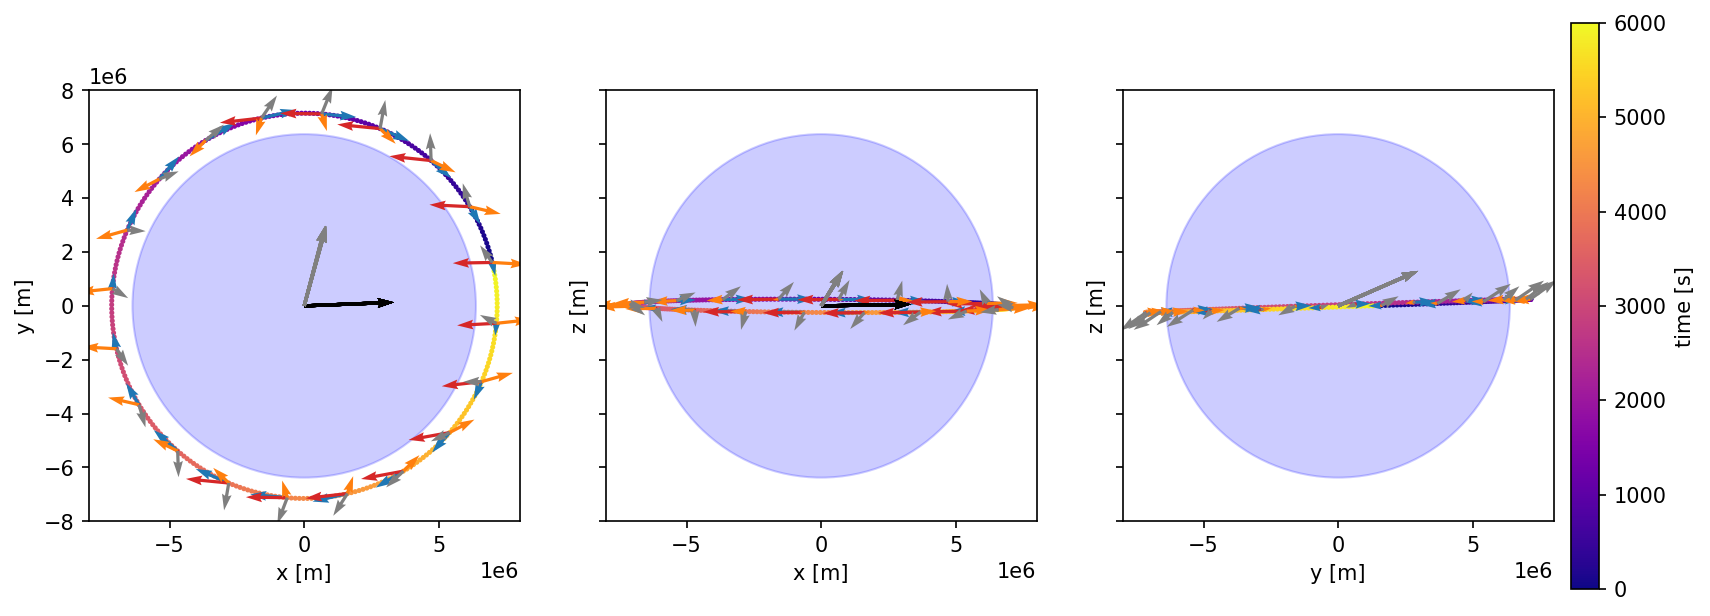

In [46]:
plot_eci(orbit)
# plt.savefig('orbit.png')

In [54]:
from observations import radar_vis


In [103]:
def radar_vis2(sECEF, stationECEF):

    stat_to_sat = sECEF[:3] - stationECEF[:3]
    stat_to_sat /= norm(stat_to_sat)
    stat = stationECEF[:3] / norm(stationECEF[:3])
    return np.dot(stat, stat_to_sat) > np.cos(90 * DEG2RAD)

In [104]:
len(orbit.t)

1000

In [111]:
solners = np.array([ecef_eci(orbit.t[i]/86400)@orbit.y[:3,i] for i in range(len(orbit.t))]).T
solnersf = orbit.y[:3]*1e3

def checker(idx):
#     ecq = ecef_eci(orbit.t[0]/86400,return_extras=True)
#     c1 = radar_vis(orbit.t[i],solnersf[:,i],s_1,ecq)
#     c2 = radar_vis(orbit.t[i],solnersf[:,i],s_2,ecq)
#     c3 = radar_vis(orbit.t[i],solnersf[:,i],s_3,ecq)
    c1 = radar_vis2(solners[:,idx],s_1)
    c2 = radar_vis2(solners[:,idx],s_2)
    c3 = radar_vis2(solners[:,idx],s_3)
    return (c1 or c2 or c3)

idx_true = [checker(i) for i in range(len(orbit.t))]



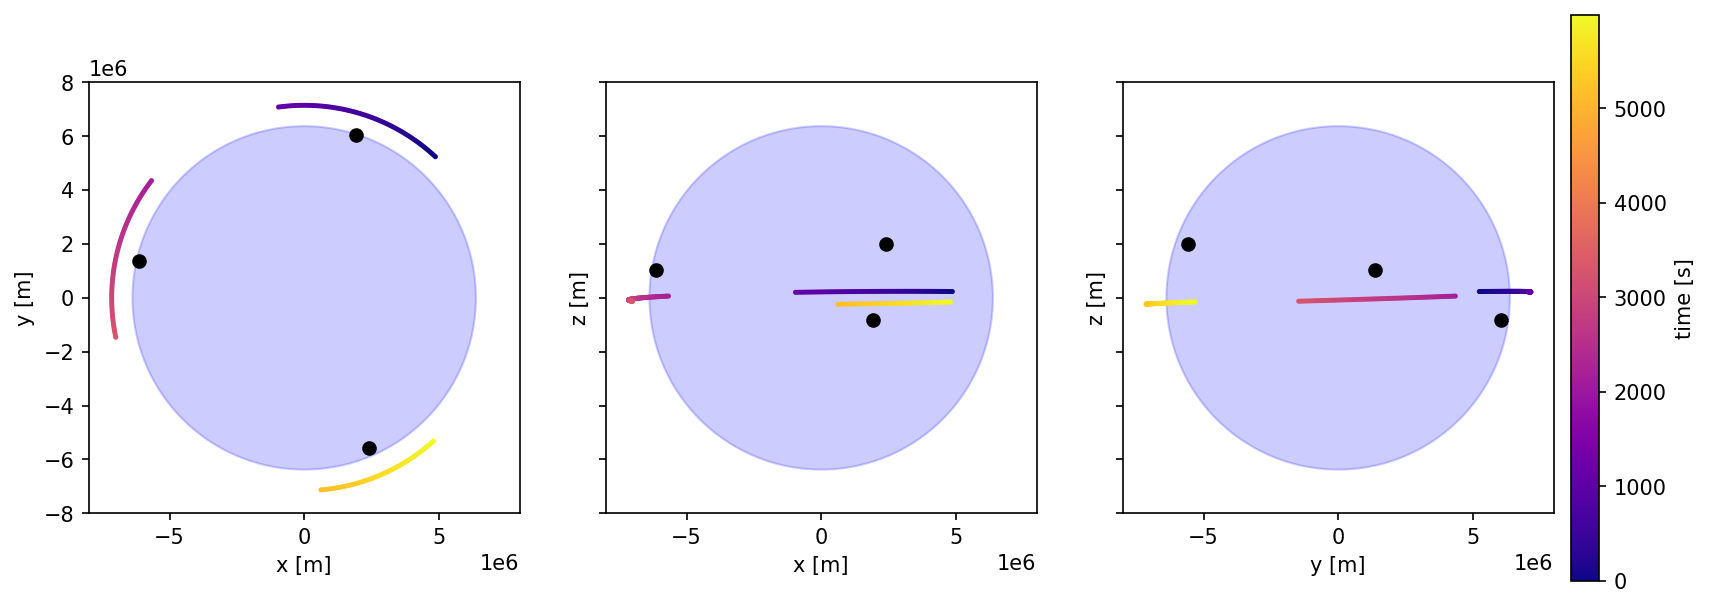

In [112]:

soln_y0 = solners[0][idx_true]
soln_y1 = solners[1][idx_true]
soln_y2 = solners[2][idx_true]
soln_t = orbit.t - min(orbit.t)

indices = np.arange(0, len(orbit), 15)



vector_scale = 1e6
scaler = 0.3

# Scale soln.t from 0 to 1
scaled_t = (soln_t - np.min(soln_t)) / (np.max(soln_t) - np.min(soln_t))

# Create a 1x3 grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.set_dpi(150)

for ax in axs:
    circle = matplotlib.patches.Circle((0, 0), Rearth, color='blue', alpha=0.2)
    ax.add_artist(circle)

# Create scatter plots for each pair of soln_y0, soln_y1, and soln_y2
sc0 = axs[0].scatter(soln_y0, soln_y1, c=scaled_t[idx_true], cmap='plasma',s=2)
axs[0].scatter(s_1[0],s_1[1],color='black')
axs[0].scatter(s_2[0],s_2[1],color='black')
axs[0].scatter(s_3[0],s_3[1],color='black')
axs[0].set_xlabel("x [m]")
axs[0].set_ylabel("y [m]")
axs[0].set_aspect('equal')
axs[0].set_xlim([-8e6,8e6])
axs[0].set_ylim([-8e6,8e6])

sc1 = axs[1].scatter(soln_y0, soln_y2, c=scaled_t[idx_true], cmap='plasma',s=2)
axs[1].scatter(s_1[0],s_1[2],color='black')
axs[1].scatter(s_2[0],s_2[2],color='black')
axs[1].scatter(s_3[0],s_3[2],color='black')
axs[1].set_xlabel("x [m]")
axs[1].set_ylabel("z [m]")
axs[1].set_aspect('equal')
axs[1].set_xlim([-8e6,8e6])
axs[1].set_ylim([-8e6,8e6])

sc2 = axs[2].scatter(soln_y1, soln_y2, c=scaled_t[idx_true], cmap='plasma',s=2)
axs[2].scatter(s_1[1],s_1[2],color='black')
axs[2].scatter(s_2[1],s_2[2],color='black')
axs[2].scatter(s_3[1],s_3[2],color='black')
axs[2].set_xlabel("y [m]")
axs[2].set_ylabel("z [m]")
axs[2].set_aspect('equal')
axs[2].set_xlim([-8e6,8e6])
axs[2].set_ylim([-8e6,8e6])

# Create a custom mappable object with the original soln.t range
mappable = ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=np.min(soln_t), vmax=np.max(soln_t)))

# Create the colorbar with the custom mappable object
cbar = fig.colorbar(mappable, ax=axs.ravel().tolist(), pad=0.01)
cbar.set_label('time [s]')

# Display the plot
#     plt.tight_layout()
plt.savefig('orbiter.png',dpi=500)
# plt.show()

In [107]:
solners[0]

array([ 6.03413891e+06,  6.15989609e+06,  6.27877627e+06,  6.39064664e+06,
        6.49538219e+06,  6.59286588e+06,  6.68298870e+06,  6.76564986e+06,
        6.84075686e+06,  6.90822561e+06,  6.96798053e+06,  7.01995460e+06,
        7.06408949e+06,  7.10033557e+06,  7.12865201e+06,  7.14900682e+06,
        7.16137686e+06,  7.16574790e+06,  7.16211460e+06,  7.15048056e+06,
        7.13085830e+06,  7.10326922e+06,  7.06774363e+06,  7.02432068e+06,
        6.97304835e+06,  6.91398336e+06,  6.84719115e+06,  6.77274578e+06,
        6.69072985e+06,  6.60123443e+06,  6.50435894e+06,  6.40021104e+06,
        6.28890655e+06,  6.17056927e+06,  6.04533091e+06,  5.91333089e+06,
        5.77471624e+06,  5.62964140e+06,  5.47826806e+06,  5.32076499e+06,
        5.15730784e+06,  4.98807896e+06,  4.81326718e+06,  4.63306762e+06,
        4.44768146e+06,  4.25731574e+06,  4.06218310e+06,  3.86250158e+06,
        3.65849436e+06,  3.45038951e+06,  3.23841974e+06,  3.02282215e+06,
        2.80383794e+06,  

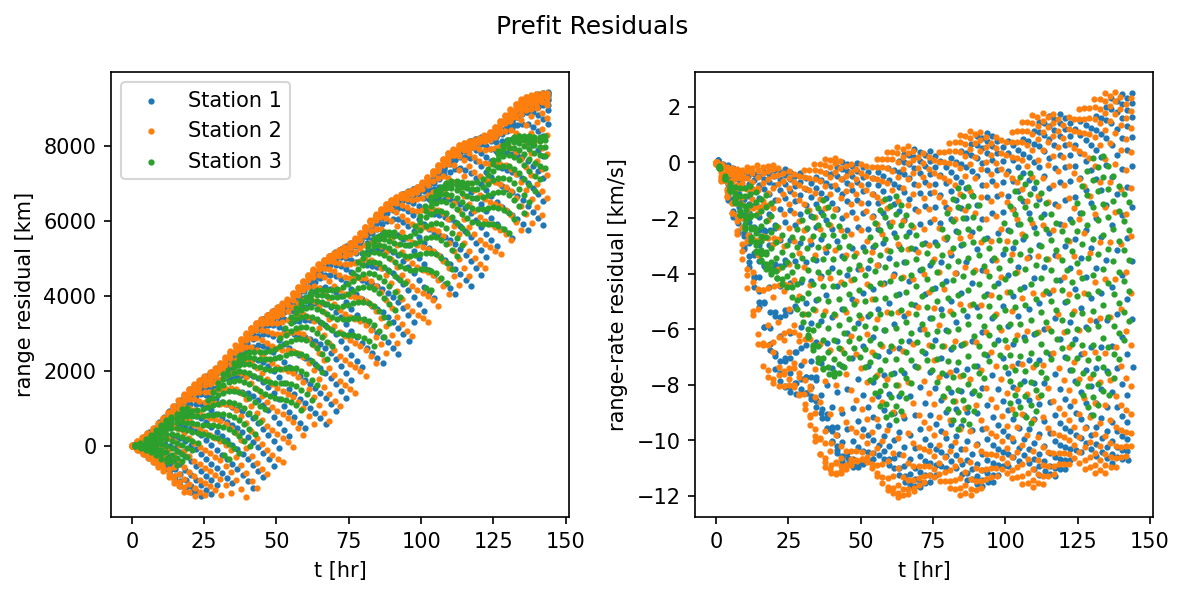

In [191]:
prefit_residuals = residuals(orbit.y.T, data, orbit.t, plot=True, plottitle='Prefit Residuals')

In [193]:
# bias1 = np.array([-10,0])
# bias2 = np.array([20,-0.11])
# bias3 = np.array([15,-0.9])

# winner !!
# bias1 = np.array([0,0])
# bias2 = np.array([-20,-0.03])
# bias3 = np.array([0,-0.4])

# bias1 = np.array([0,0])
# bias2 = np.array([-22,-0.03])
# bias3 = np.array([0,-0.4])

def EKF(s_i, epoch, data, position_stddev=1e4, velocity_stddev=10, s1_R=None, s2_R=None, s3_R=None, bias1=np.zeros(2),bias2=np.zeros(2),bias3=np.zeros(2)):
    # Initialization
    # X*_i-1
    X = np.array([*s_i,Cd])
    # P_i-1
    P = np.diag(np.concatenate([np.ones(3)*position_stddev**2,np.ones(3)*velocity_stddev**2,np.ones(1)*1e-3]))
    # Phi_(t0,t0)
    Phi = np.eye(7)
    # Epoch of initial state (s)
    t_0 = epoch * 86400
    t_prev = t_0

    # Set empty lists for updated positions, covariances, and STMs
    Xhats = []
    Phats = []
    Phis = []
    Ss = []

    # Loop over all the measurements in the data
    for i in tqdm(range(0,data.shape[0])):
        dt = data[i,1]  # Time passed from initial epoch at the time of the measurement (s)
        t_next = t_0 + dt  # Absolute time of measurement (s)
        station_id = data[i,0]
        
        # Read in the measurement for this observation
        Y = data[i,2:4]*1e3  # m, m/s
        if station_id == 1:
            Y += bias1
        if station_id == 2:
            Y += bias2
        if station_id == 3:
            Y += bias3

        # Set the R matrix based on this station
        if station_id == 1:
            # If R is not supplied, use a default value
            if s1_R is None:
                range_sigma = 10  # m
                rate_sigma = 0.5*1e-3  # m/s
                R = np.array([[range_sigma**2, 0], [0, rate_sigma**2]])
            # Otherwise use the given value
            else:
                R = s1_R
        elif station_id == 2:
            if s2_R is None:
                range_sigma = 5  # m
                rate_sigma = 1*1e-3  # m/s
                R = np.array([[range_sigma**2, 0], [0, rate_sigma**2]])
            else:
                R = s2_R
        elif station_id == 3:
            if s3_R is None:
                range_sigma = 10  # m
                rate_sigma = 0.5*1e-3  # m/s
                R = np.array([[range_sigma**2, 0], [0, rate_sigma**2]])
            else:
                R = s3_R

        if i==0:
            # Assume the first observation occurs at t=t_0 and do not propagate.
            # But make sure this assumption is true with the following assertion!
            assert t_prev == t_next
        # Otherwise, propagate the state at the previous observation to this observation
        elif i > 0:
            Phi = np.eye(7)
            flat_state = np.concatenate([Xhat,Phi.flatten()])
            t_eval = np.array([t_prev, t_next])
            solution = scipy.integrate.solve_ivp(
                F,
                t_span = [t_eval[0], t_eval[-1]],
                t_eval = t_eval,
                y0 = flat_state,
                rtol=1e-10,
                atol=1e-12
            )
            X = solution.y[:7,-1]
            Phi = solution.y[7:,-1].reshape((7,7))  # STM from the previous measurement to this one
        
        # Time update:
        P = Phi @ P @ Phi.T + Q(t_next - t_prev, 1e-8, 1e-8, 1e-8)
        t_prev = t_next
        
        # Intermediate computations
        Htilde = H(X, t_next, station_id)
        y = Y - G(X, t_next, station_id)
        S = Htilde @ P @ Htilde.T + R
        K = P @ Htilde.T @ np.linalg.inv(S)
        
        # Measurement update
        Xhat = X + K @ y
        I_KH = (np.eye(7) - K @ Htilde)
        Phat = I_KH @ P @ I_KH.T + K @ R @ K.T
        P = Phat
        
        # Store variables
        Xhats.append(Xhat)
        Phats.append(Phat)
        Phis.append(Phi)
        Ss.append(S)

        Phi = np.eye(7)
    
    return Xhats, Phats, Phis, Ss

def residuals(prediction, data, t, plot=False, showall=None, plottitle='residuals',Ss=None):
    idx_1 = np.where(data[:,0] == 1)
    idx_2 = np.where(data[:,0] == 2)
    idx_3 = np.where(data[:,0] == 3)

    ti = min(t)

    obs1 = np.array([[1,t-ti,*G(s, t, 1)/1e3] for t,s in zip(t[idx_1], prediction[idx_1])])
    obs2 = np.array([[1,t-ti,*G(s, t, 2)/1e3] for t,s in zip(t[idx_2], prediction[idx_2])])
    obs3 = np.array([[1,t-ti,*G(s, t, 3)/1e3] for t,s in zip(t[idx_3], prediction[idx_3])])

    residuals = np.zeros_like(data)
    residuals[:,0] = data[:,0]
    residuals[:,1] = data[:,1]
    residuals[idx_1,2] = obs1[:,2] - data[idx_1,2] + bias1[0]*-1e-3
    residuals[idx_2,2] = obs2[:,2] - data[idx_2,2] + bias2[0]*-1e-3
    residuals[idx_3,2] = obs3[:,2] - data[idx_3,2] + bias3[0]*-1e-3
    residuals[idx_1,3] = obs1[:,3] - data[idx_1,3] + bias1[1]*-1e-3
    residuals[idx_2,3] = obs2[:,3] - data[idx_2,3] + bias2[1]*-1e-3
    residuals[idx_3,3] = obs3[:,3] - data[idx_3,3] + bias3[1]*-1e-3

    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        fig.set_dpi(150)
        axs[0].scatter(obs1[:,1]/3600, residuals[idx_1,2], label='Station 1', s=4)
        axs[0].scatter(obs2[:,1]/3600, residuals[idx_2,2], label='Station 2', s=4)
        axs[0].scatter(obs3[:,1]/3600, residuals[idx_3,2], label='Station 3', s=4)
        axs[0].set_xlabel('t [hr]')
        axs[0].set_ylabel('range residual [km]')
        axs[0].legend()
        axs[1].scatter(obs1[:,1]/3600, residuals[idx_1,3], s=4)
        axs[1].scatter(obs2[:,1]/3600, residuals[idx_2,3], s=4)
        axs[1].scatter(obs3[:,1]/3600, residuals[idx_3,3], s=4)
        axs[1].set_xlabel('t [hr]')
        axs[1].set_ylabel('range-rate residual [km/s]')
        if Ss is not None:
            range_3covs = [3*np.sqrt(S[0,0])/1e3 for S in SsF]
            range_rate_3covs = [3*np.sqrt(S[1,1])/1e3 for S in SsF]
            axs[0].plot(data[:,1]/3600,range_3covs,alpha=0.7,color='grey')
            axs[0].plot(data[:,1]/3600,-np.array(range_3covs),alpha=0.7,color='grey')
            axs[1].plot(data[:,1]/3600,range_rate_3covs,alpha=0.7,color='grey',label='3$\sigma$')
            axs[1].plot(data[:,1]/3600,-np.array(range_rate_3covs),alpha=0.7,color='grey')
            mindata_rate = min(residuals[:,3])
            maxdata_rate = max(residuals[:,3])
            mindata_range = min(residuals[:,2])
            maxdata_range = max(residuals[:,2])
            axs[0].set_ylim([mindata_range,maxdata_range])
            axs[1].set_ylim([mindata_rate,maxdata_rate])
            
            axs[1].legend()
        if showall is not None:
            integ = data[-1,1] * showall
            axs[0].set_xlim([0,integ/3600])
            axs[1].set_xlim([0,integ/3600])
        fig.suptitle(plottitle)
        plt.tight_layout()
        plt.show()

    return residuals

In [171]:
def run_comp_bias():
    bias1 = np.array([0,0.4])
    bias2 = np.array([-20,0.03])
    bias3 = np.array([0,-0.4])

    XhatsF, PhatsF, PhisF, SsF = EKF(s_i, init_epoch, data, position_stddev=10e3, velocity_stddev=10, bias1=bias1,bias2=bias2,bias3=bias3)
    delivery_stateF, delivery_covF = propagate_to_delivery(XhatsF[-1], PhatsF[-1], data[-1,1]+init_epoch_s, init_epoch_s+86400)
#     truth = np.array([6985.31847,1621.22693,15.733135849,-1.674296469,7.2592352307,0.261383935])*1e3
    truth = np.array([-6330.16736001325,3306.81591178162,127.736863438565,-3.43787907681733,-6.63350511630163,-0.235613730204275])*1e3
    print(delivery_stateF - truth)
    return norm(delivery_stateF - truth)

In [166]:
run_comp_bias()

100%|█████████████████████████████████████████| 435/435 [00:43<00:00,  9.96it/s]


[-2.42986778e+02  3.28249723e+02  5.00968923e+02 -2.59192161e-01
  5.51014370e-01 -9.84434363e-02]


646.3441013586583

In [172]:
run_comp_bias()

100%|█████████████████████████████████████████| 435/435 [00:47<00:00,  9.24it/s]


[-2.42845574e+02  3.28942054e+02  5.01476768e+02 -2.55834326e-01
  5.49809345e-01 -1.01115432e-01]


647.0364555820921

In [154]:
run_comp_bias()

100%|█████████████████████████████████████████| 435/435 [00:43<00:00,  9.90it/s]


[-1.90332427e+02  4.31292725e+02  5.13440414e+02 -3.51560819e-01
  5.95003296e-01 -1.03638221e-01]


697.0375846850798

# Run cases

## Start with case F

In [202]:
bias1 = np.array([70,0.4])
bias2 = np.array([-20,-0.03])
bias3 = np.array([0,-0.4])
XhatsF, PhatsF, PhisF, SsF = EKF(s_i, init_epoch, data, position_stddev=10e3, velocity_stddev=10, bias1=bias1,bias2=bias2,bias3=bias3)
delivery_stateF, delivery_covF = propagate_to_delivery(XhatsF[-1], PhatsF[-1], data[-1,1]+init_epoch_s, init_epoch_s+86400)
assert np.all(np.linalg.eigvals(delivery_covF) > 0)

# Xhats_arr = np.array(Xhats0)
# xhi = Xhats_arr[0]/1e3
# print(xhi[0] - 6985.31847)
# print(xhi[1] - 1621.22693)
# print(xhi[2] - 15.733135849)
# print((xhi[3] - (-1.674296469))*1e3)
# print((xhi[4] - 7.2592352307)*1e3)
# print((xhi[5] - 0.261383935)*1e3)
# print(xhi)

100%|█████████████████████████████████████████| 435/435 [00:44<00:00,  9.68it/s]


In [168]:
Xhats_arr = np.array(XhatsF)
xhi = Xhats_arr[0]/1e3
print(xhi[0] - 6985.31847)
print(xhi[1] - 1621.22693)
print(xhi[2] - 15.733135849)
print((xhi[3] - (-1.674296469))*1e3)
print((xhi[4] - 7.2592352307)*1e3)
print((xhi[5] - 0.261383935)*1e3)
print(xhi)

-0.012165987664957356
0.005001494933367212
-0.008996675997900994
-0.0015278592844225614
0.0014116359805527168
-0.0009736966037898753
[ 6.98530630e+03  1.62123193e+03  1.57241392e+01 -1.67429800e+00
  7.25923664e+00  2.61382961e-01  1.88000000e-03]


In [136]:
Xhats_arr = np.array(XhatsF)
xhi = Xhats_arr[0]/1e3
print(xhi[0] - 6985.31847)
print(xhi[1] - 1621.22693)
print(xhi[2] - 15.733135849)
print((xhi[3] - (-1.674296469))*1e3)
print((xhi[4] - 7.2592352307)*1e3)
print((xhi[5] - 0.261383935)*1e3)
print(xhi)

-0.013499949336619466
0.006234583290051887
-0.00983335835367427
-0.0015278592844225614
0.0014116359805527168
-0.0009736966037898753
[ 6.98530497e+03  1.62123316e+03  1.57233025e+01 -1.67429800e+00
  7.25923664e+00  2.61382961e-01  1.88000000e-03]


In [32]:
Xhats_arr = np.array(XhatsF)
xhi = Xhats_arr[0]/1e3
print(xhi[0] - 6985.31847)
print(xhi[1] - 1621.22693)
print(xhi[2] - 15.733135849)
print((xhi[3] - (-1.674296469))*1e3)
print((xhi[4] - 7.2592352307)*1e3)
print((xhi[5] - 0.261383935)*1e3)
print(xhi)

0.005441758559754817
0.0008771487885042006
0.004659926333250297
0.0014354171009589578
-0.0013275593708783617
0.0008849183177894737
[ 6.98532391e+03  1.62122781e+03  1.57377958e+01 -1.67429503e+00
  7.25923390e+00  2.61384820e-01  1.88000000e-03]


In [33]:
Xhats_arr = np.array(XhatsF)
xhi = Xhats_arr[0]/1e3
print(xhi[0] - 6985.31847)
print(xhi[1] - 1621.22693)
print(xhi[2] - 15.733135849)
print((xhi[3] - (-1.674296469))*1e3)
print((xhi[4] - 7.2592352307)*1e3)
print((xhi[5] - 0.261383935)*1e3)
print(xhi)

0.005441758559754817
0.0008771487885042006
0.004659926333250297
0.0014354171009589578
-0.0013275593708783617
0.0008849183177894737
[ 6.98532391e+03  1.62122781e+03  1.57377958e+01 -1.67429503e+00
  7.25923390e+00  2.61384820e-01  1.88000000e-03]


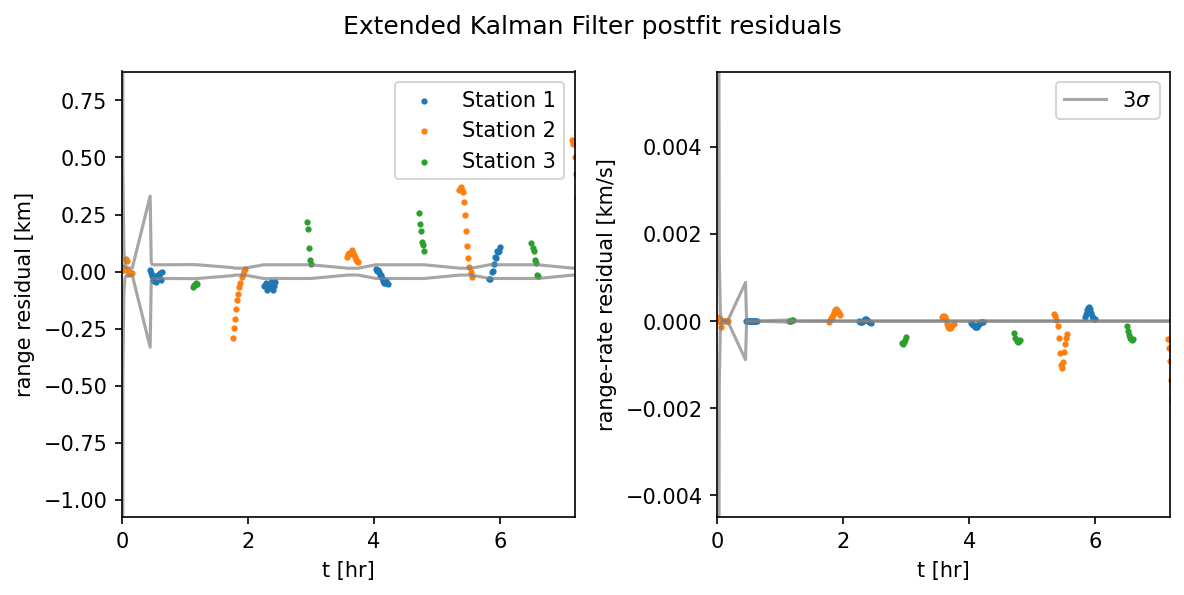

In [60]:
postfit_residuals = residuals(np.array(XhatsF), data, orbit.t, Ss=SsF, plot=True, showall=0.3, plottitle='Extended Kalman Filter postfit residuals')
# 0

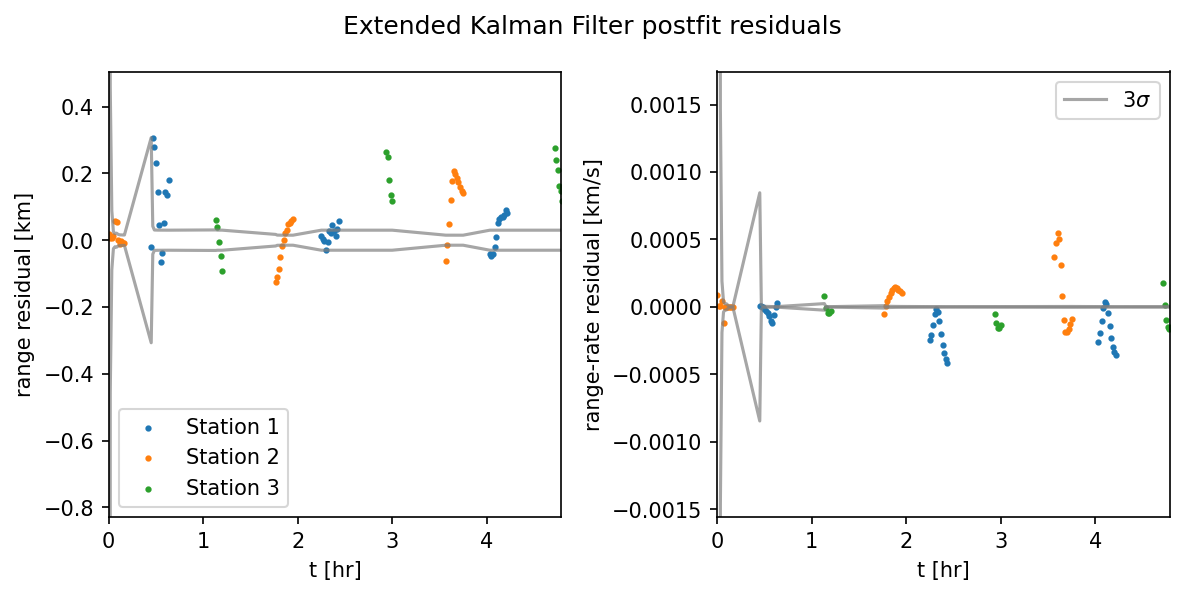

In [170]:
postfit_residuals = residuals(np.array(XhatsF), data, orbit.t, Ss=SsF, plot=True, showall=0.2, plottitle='Extended Kalman Filter postfit residuals')
# -0.4

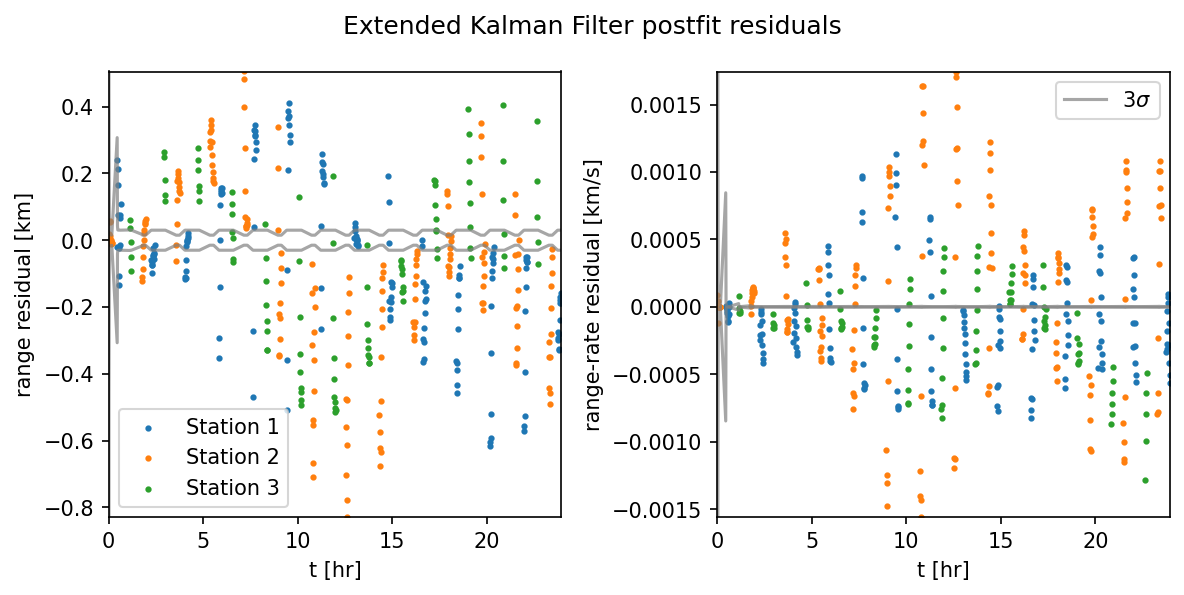

In [204]:
postfit_residuals = residuals(np.array(XhatsF), data, orbit.t, Ss=SsF, plot=True, showall=1, plottitle='Extended Kalman Filter postfit residuals')
# -0.7

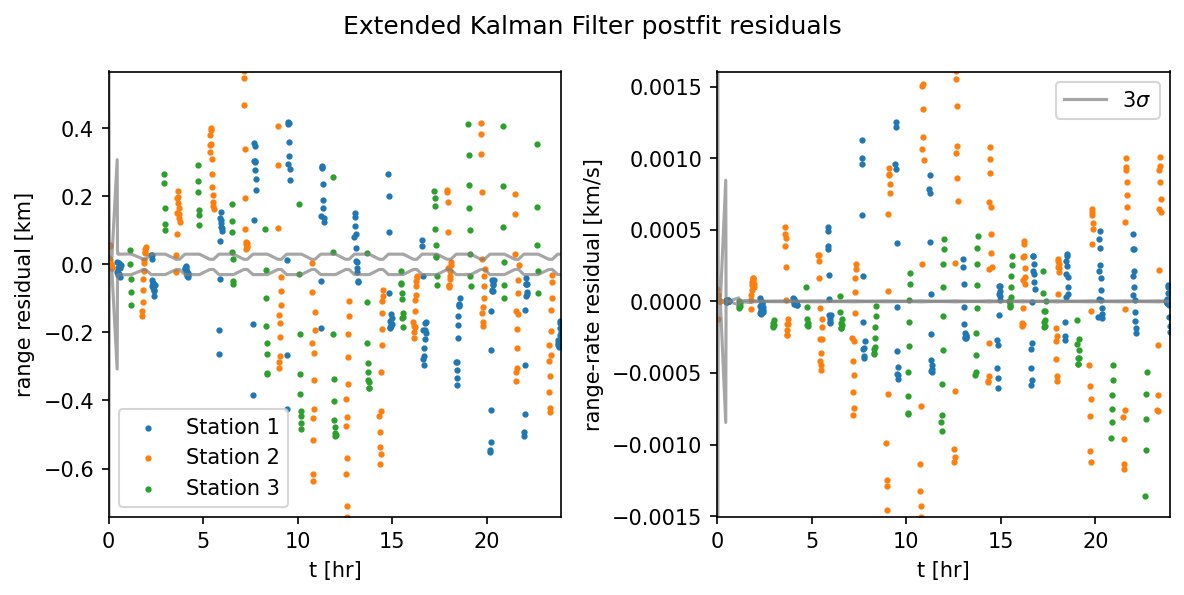

In [135]:
postfit_residuals = residuals(np.array(XhatsF), data, orbit.t, Ss=SsF, plot=True, showall=1, plottitle='Extended Kalman Filter postfit residuals')
# -0.85

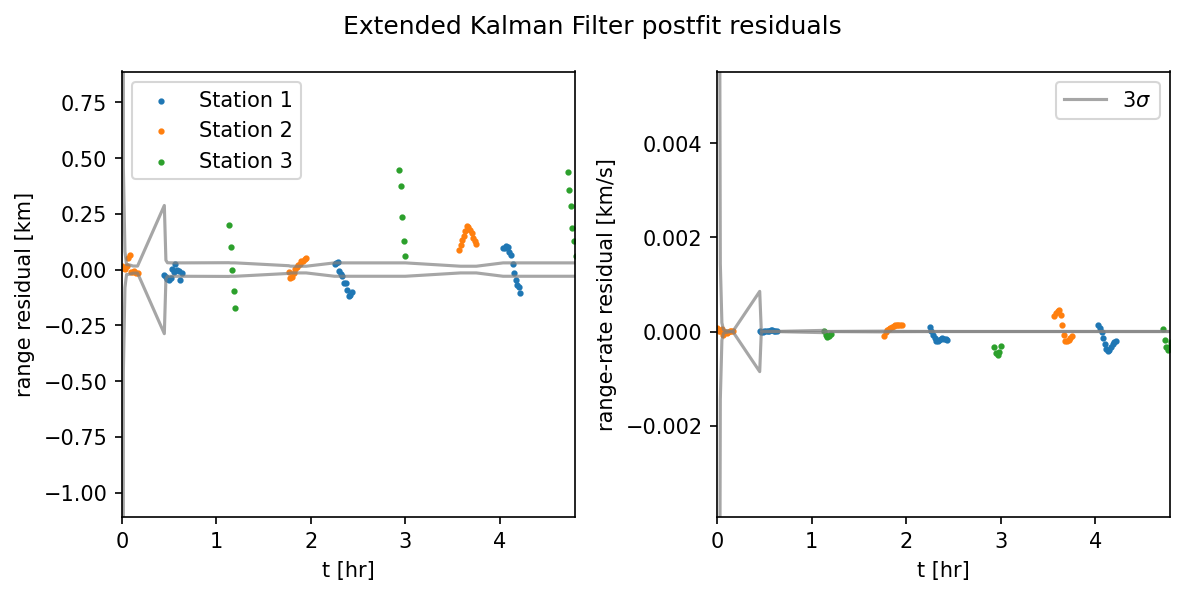

In [77]:
postfit_residuals = residuals(np.array(XhatsF), data, orbit.t, Ss=SsF, plot=True, showall=0.2, plottitle='Extended Kalman Filter postfit residuals')
# -0.02, -0.07, -0.9

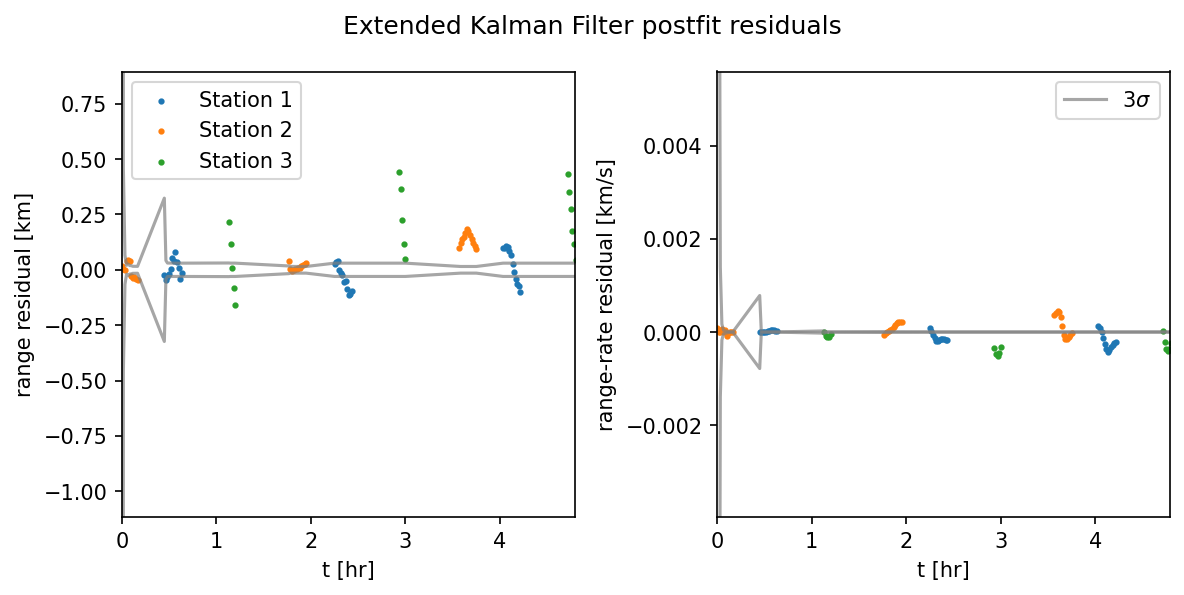

In [80]:
postfit_residuals = residuals(np.array(XhatsF), data, orbit.t, Ss=SsF, plot=True, showall=0.2, plottitle='Extended Kalman Filter postfit residuals')
# -0.02, -0.15, -0.9

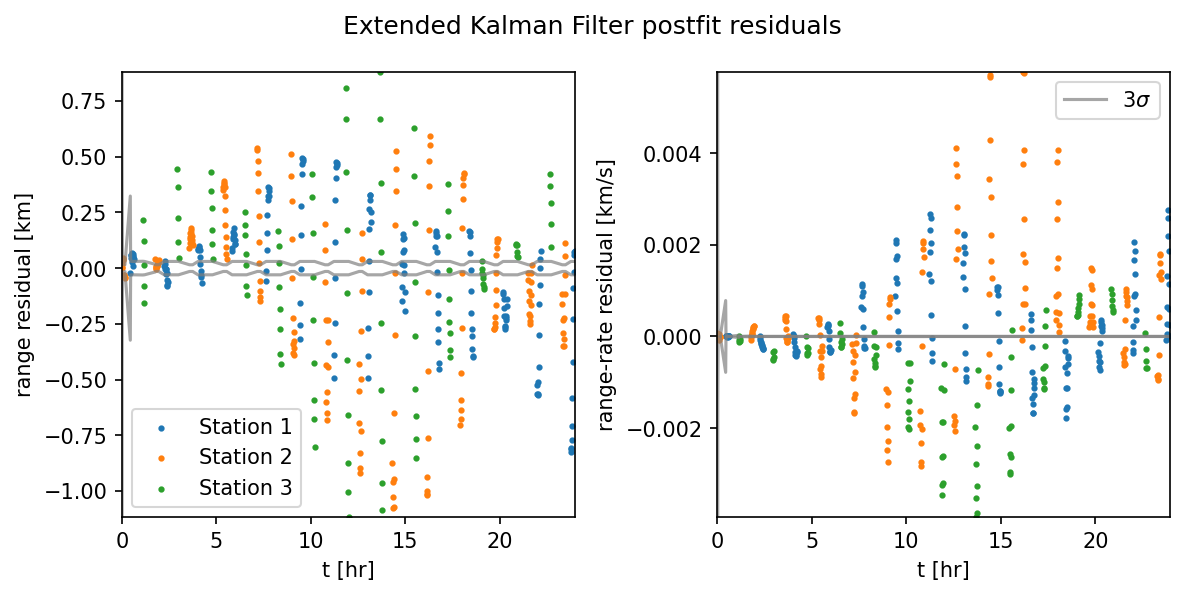

In [88]:
postfit_residuals = residuals(np.array(XhatsF), data, orbit.t, Ss=SsF, plot=True, showall=1, plottitle='Extended Kalman Filter postfit residuals')
# 0.1, -0.15, -0.9

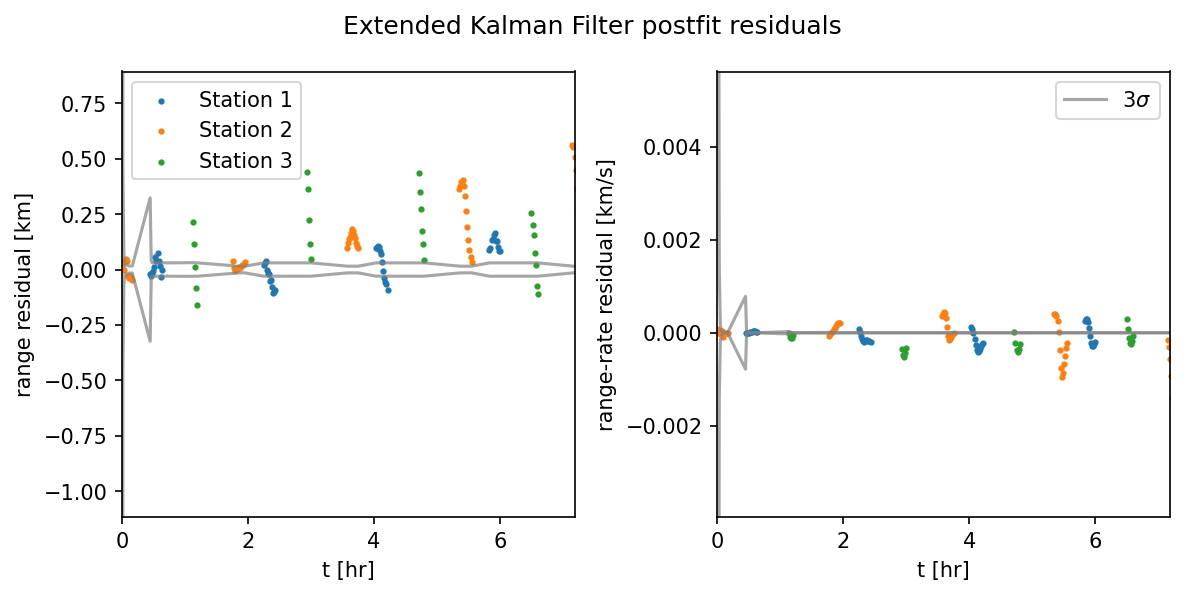

In [93]:
postfit_residuals = residuals(np.array(XhatsF), data, orbit.t, Ss=SsF, plot=True, showall=0.3, plottitle='Extended Kalman Filter postfit residuals')
# 0.0, -0.15, -0.9

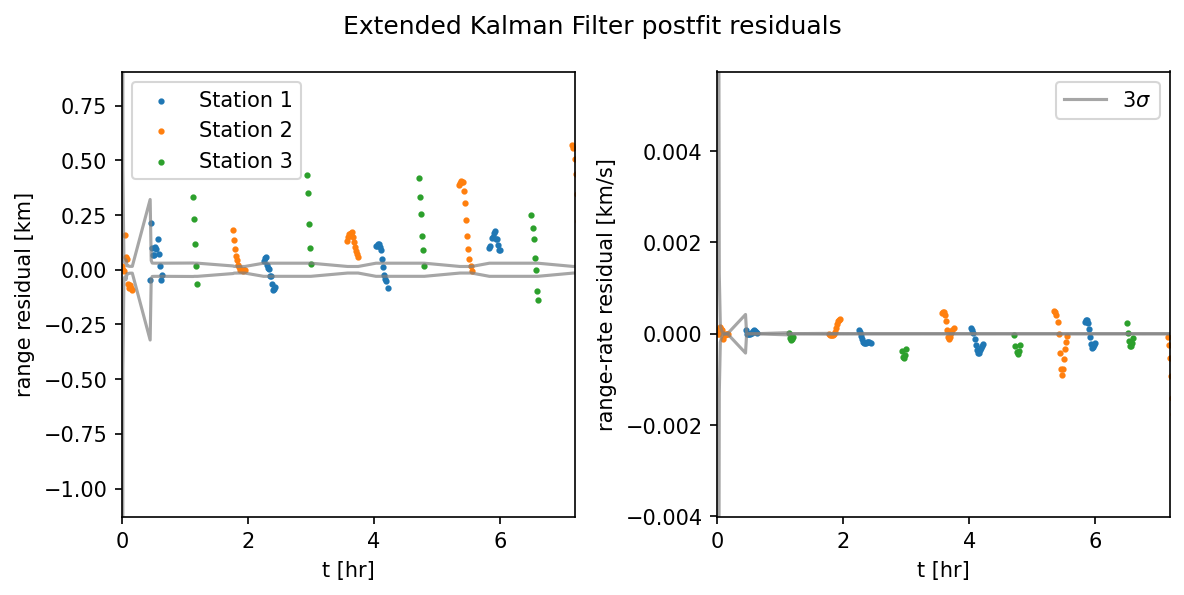

In [96]:
postfit_residuals = residuals(np.array(XhatsF), data, orbit.t, Ss=SsF, plot=True, showall=0.3, plottitle='Extended Kalman Filter postfit residuals')
# 0.0, -0.3, -0.9

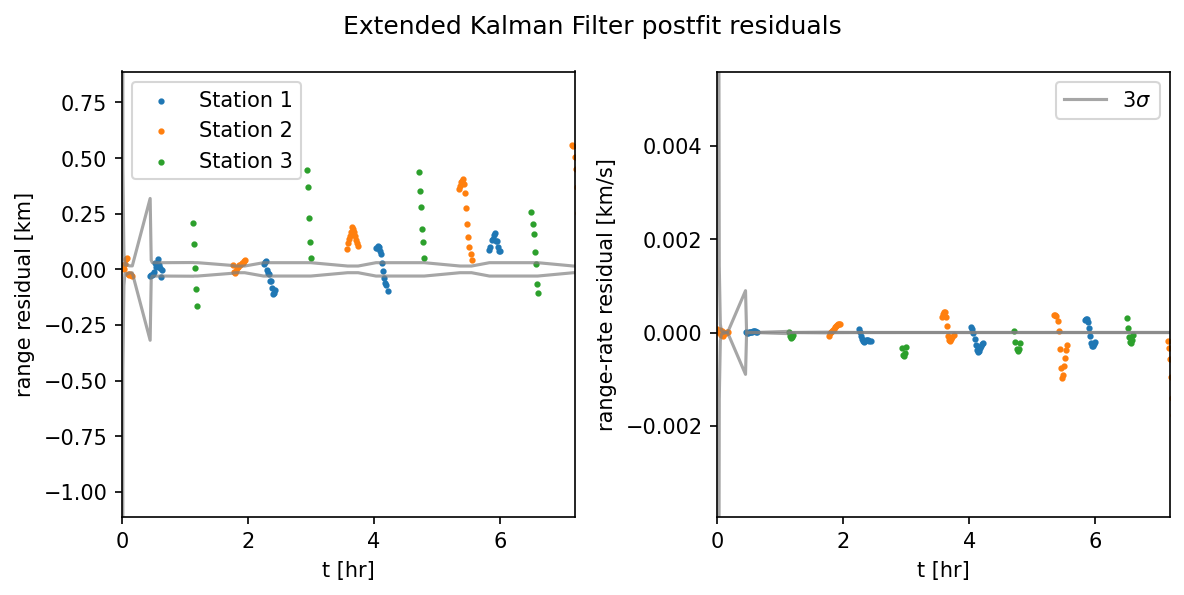

In [99]:
postfit_residuals = residuals(np.array(XhatsF), data, orbit.t, Ss=SsF, plot=True, showall=0.3, plottitle='Extended Kalman Filter postfit residuals')
# 0.0, -0.11, -0.9

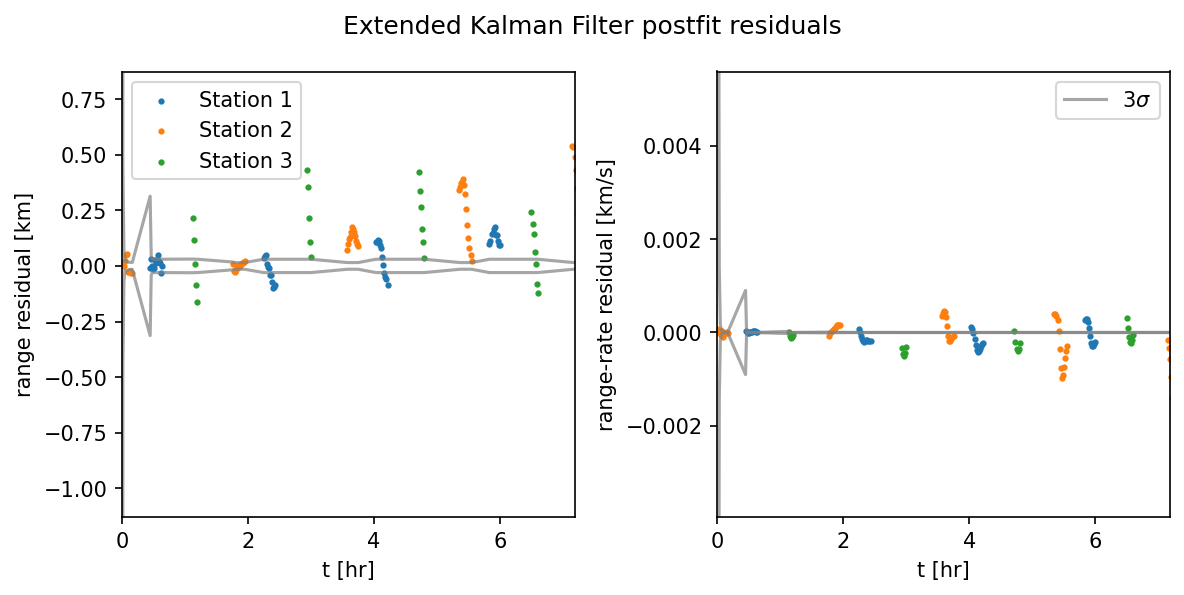

In [111]:
postfit_residuals = residuals(np.array(XhatsF), data, orbit.t, Ss=SsF, plot=True, showall=0.3, plottitle='Extended Kalman Filter postfit residuals')
# -10, 20, 15
# 0.0, -0.11, -0.9

In [14]:
np.array(XhatsF)[:10].shape

(10, 7)

In [7]:
for x in delivery_stateF[:6]/1e3:
    print(x)

-6330.494652305363
3307.2892033539997
128.3175721507924
-3.43829390063124
-6.6326940318682945
-0.23590885604163217


In [8]:
-6330.16736001325
3306.81591178162
127.736863438565
-3.43787907681733
-6.63350511630163
-0.235613730204275

-0.235613730204275

## Case A

In [10]:
XhatsA, PhatsA, PhisA, SsA = EKF(s_i, init_epoch, data, position_stddev=1e3, velocity_stddev=10,
                            s1_R = np.array([[10**2, 0], [0, 1e20]]),
                            s2_R = np.array([[5**2, 0], [0, 1e20]]),
                            s3_R = np.array([[10**2, 0], [0, 1e20]]),
                           )

100%|█████████████████████████████████████████| 435/435 [00:47<00:00,  9.16it/s]


In [11]:
delivery_stateA, delivery_covA = propagate_to_delivery(XhatsA[-1], PhatsA[-1], data[-1,1]+init_epoch_s, fin_epoch_s)

## Case B

In [12]:
XhatsB, PhatsB, PhisB, SsB = EKF(s_i, init_epoch, data, position_stddev=1e3, velocity_stddev=10,
                            s1_R = np.array([[1e20, 0], [0, (0.5*1e-3)**2]]),
                            s2_R = np.array([[1e20, 0], [0, (1*1e-3)**2]]),
                            s3_R = np.array([[1e20, 0], [0, (0.5*1e-3)**2]]),
                           )

100%|█████████████████████████████████████████| 435/435 [00:43<00:00, 10.00it/s]


In [13]:
delivery_stateB, delivery_covB = propagate_to_delivery(XhatsB[-1], PhatsB[-1], data[-1,1]+init_epoch_s, fin_epoch_s)

## Case C

In [14]:
XhatsC, PhatsC, PhisC, SsC = EKF(s_i, init_epoch, data, position_stddev=1e3, velocity_stddev=10,
                            s1_R = None,
                            s2_R = np.array([[1e20, 0], [0, 1e20]]),
                            s3_R = np.array([[1e20, 0], [0, 1e20]]),
                           )

100%|█████████████████████████████████████████| 435/435 [00:44<00:00,  9.78it/s]


In [15]:
delivery_stateC, delivery_covC = propagate_to_delivery(XhatsC[-1], PhatsC[-1], data[-1,1]+init_epoch_s, fin_epoch_s)

## Case D

In [16]:
XhatsD, PhatsD, PhisD, SsD = EKF(s_i, init_epoch, data, position_stddev=1e3, velocity_stddev=10,
                            s1_R = np.array([[1e20, 0], [0, 1e20]]),
                            s2_R = None,
                            s3_R = np.array([[1e20, 0], [0, 1e20]]),
                           )

100%|█████████████████████████████████████████| 435/435 [00:53<00:00,  8.20it/s]


In [17]:
delivery_stateD, delivery_covD = propagate_to_delivery(XhatsD[-1], PhatsD[-1], data[-1,1]+init_epoch_s, fin_epoch_s)

## Case E

In [18]:
XhatsE, PhatsE, PhisE, SsE = EKF(s_i, init_epoch, data, position_stddev=1e3, velocity_stddev=10,
                            s1_R = np.array([[1e10, 0], [0, 1e10]]),
                            s2_R = np.array([[1e10, 0], [0, 1e10]]),
                            s3_R = None,
                           )

100%|█████████████████████████████████████████| 435/435 [00:40<00:00, 10.63it/s]


In [19]:
delivery_stateE, delivery_covE = propagate_to_delivery(XhatsE[-1], PhatsE[-1], data[-1,1]+init_epoch_s, fin_epoch_s)

# Save mat file with cases

In [20]:
mat_dict = {}
pos_prefix = 'koenig_pos_case'
cov_prefix = 'koenig_poscov_case'
for state,cov,case in zip(
    [delivery_stateA, delivery_stateB, delivery_stateC, delivery_stateD, delivery_stateE, delivery_stateF],
    [delivery_covA, delivery_covB, delivery_covC, delivery_covD, delivery_covE, delivery_covF],
    ['A', 'B', 'C', 'D', 'E', 'F']
):
    mat_dict[pos_prefix+case] = np.atleast_2d(state[:3]/1e3).T
    mat_dict[cov_prefix+case] = cov[:3,:3]/1e6

scipy.io.savemat('koenig_1day.mat',mat_dict)

In [21]:
scipy.io.loadmat('koenig.mat')

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Thu Apr 20 01:26:14 2023',
 '__version__': '1.0',
 '__globals__': [],
 'koenig_pos_caseA': array([[  432.89122033],
        [-7100.80142158],
        [ -191.17957766]]),
 'koenig_poscov_caseA': array([[4.34531082e-03, 4.77850868e-05, 1.85362891e-05],
        [4.77850868e-05, 3.58685200e-03, 1.16314149e-06],
        [1.85362891e-05, 1.16314149e-06, 3.58448761e-03]]),
 'koenig_pos_caseB': array([[  417.99542708],
        [-7101.68406265],
        [ -191.51479266]]),
 'koenig_poscov_caseB': array([[3.88023455e-03, 1.82991653e-05, 7.16763103e-06],
        [1.82991653e-05, 3.58493852e-03, 4.42431004e-07],
        [7.16763103e-06, 4.42431004e-07, 3.58398261e-03]]),
 'koenig_pos_caseC': array([[  598.59578437],
        [-7084.23247957],
        [ -194.71051701]]),
 'koenig_poscov_caseC': array([[3.92095794e-03, 2.96412815e-05, 8.67313024e-06],
        [2.96412815e-05, 3.58641602e-03, 7.61823729e-07],
        [8.67313024e-06, 7.

In [185]:
bias1 = np.array([0,0.4])
bias2 = np.array([-20,-0.03])
bias3 = np.array([0,-0.4])
XhatsF, PhatsF, PhisF, SsF = EKF(s_i, init_epoch, all_data, position_stddev=1e3, velocity_stddev=10, bias1=bias1,bias2=bias2,bias3=bias3)
delivery_stateF, delivery_covF = propagate_to_delivery(XhatsF[-1], PhatsF[-1], all_data[-1,1]+init_epoch_s, init_epoch_s+7*86400)
assert np.all(np.linalg.eigvals(delivery_covF) > 0)

100%|███████████████████████████████████████| 2570/2570 [05:01<00:00,  8.53it/s]


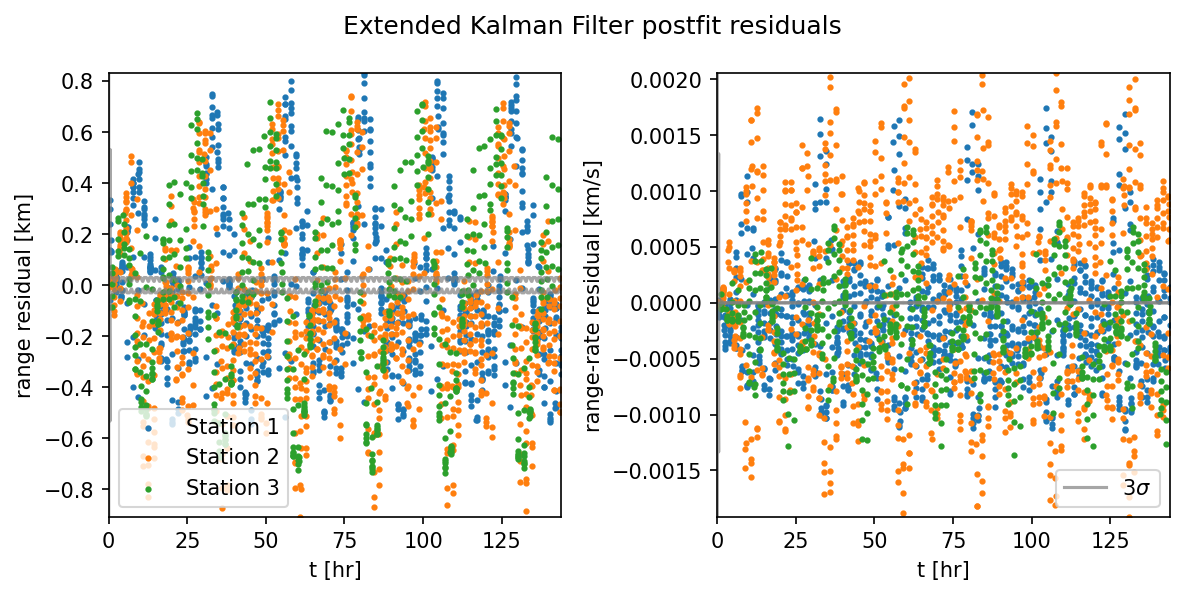

In [194]:
postfit_residuals = residuals(np.array(XhatsF), all_data, orbit.t, Ss=SsF, plot=True, showall=1, plottitle='Extended Kalman Filter postfit residuals')
# 0

In [198]:
XhatsA, PhatsA, PhisA, SsA = EKF(s_i, init_epoch, all_data, position_stddev=1e3, velocity_stddev=10,
                            s1_R = np.array([[10**2, 0], [0, 1e20]]),
                            s2_R = np.array([[5**2, 0], [0, 1e20]]),
                            s3_R = np.array([[10**2, 0], [0, 1e20]]),
                                 bias1=bias1,
                                 bias2=bias2,
                                 bias3=bias3
                           )

100%|███████████████████████████████████████| 2570/2570 [05:20<00:00,  8.01it/s]


In [199]:
delivery_stateA, delivery_covA = propagate_to_delivery(XhatsA[-1], PhatsA[-1], all_data[-1,1]+init_epoch_s, fin_epoch_s)

In [200]:
mat_dict = {}
pos_prefix = 'koenig_pos_case'
cov_prefix = 'koenig_poscov_case'
for state,cov,case in zip(
    [delivery_stateA, delivery_stateF],
    [delivery_covA, delivery_covF],
    ['A','F']
):
    mat_dict[pos_prefix+case] = np.atleast_2d(state[:3]/1e3).T
    mat_dict[cov_prefix+case] = cov[:3,:3]/1e6

scipy.io.savemat('koenig_7day2.mat',mat_dict)

In [201]:
scipy.io.loadmat('koenig_7day2.mat')

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Tue Apr 25 13:31:38 2023',
 '__version__': '1.0',
 '__globals__': [],
 'koenig_pos_caseA': array([[  440.70583283],
        [-7100.40962028],
        [ -189.03420627]]),
 'koenig_poscov_caseA': array([[3.33494456e-04, 2.11702353e-05, 7.80094130e-06],
        [2.11702353e-05, 1.54085109e-05, 5.21116977e-07],
        [7.80094130e-06, 5.21116977e-07, 1.42535023e-05]]),
 'koenig_pos_caseF': array([[  433.38506972],
        [-7100.90152144],
        [ -186.06841377]]),
 'koenig_poscov_caseF': array([[5.37941701e-05, 2.87169408e-06, 9.73897815e-07],
        [2.87169408e-06, 1.41392352e-05, 6.97135685e-08],
        [9.73897815e-07, 6.97135685e-08, 1.39588928e-05]])}

In [46]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.linalg import eigh

def plot_covariances(cov_matrices, state_vectors):
    """
    Provide values in the form:
    cov_matrices = {letter:cov for letter,cov in zip(['A','B','C','F'],[delivery_covA, delivery_covB, delivery_covC, delivery_covF])}
    state_vectors = {letter:cov for letter,cov in zip(['A','B','C','F'],[delivery_stateA, delivery_stateB, delivery_stateC, delivery_stateF])}
    """
    def confidence_ellipse(ax,cov, mean, edgecolor, facecolor, label, nstd=3.0):
        """
        Create a plot of the covariance confidence ellipse of *x* and *y*.

        Parameters
        ----------
        x, y : array-like, shape (n, )
            Input data.

        ax : matplotlib.axes.Axes
            The axes object to draw the ellipse into.

        n_std : float
            The number of standard deviations to determine the ellipse's radiuses.

        **kwargs
            Forwarded to `~matplotlib.patches.Ellipse`

        Returns
        -------
        matplotlib.patches.Ellipse
        """
    #     if x.size != y.size:
    #         raise ValueError("x and y must be the same size")

    #     cov = np.cov(x, y)
        pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
        # Using a special case to obtain the eigenvalues of this
        # two-dimensional dataset.
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                        facecolor=facecolor,edgecolor=edgecolor,label=label)
                        #facecolor=facecolor,
    #                       **kwargs)

        # Calculating the standard deviation of x from
        # the squareroot of the variance and multiplying
        # with the given number of standard deviations.
        scale_x = np.sqrt(cov[0, 0]) * nstd
    #     mean_x = np.mean(x)
        mean_x = mean[0]

        # calculating the standard deviation of y ...
        scale_y = np.sqrt(cov[1, 1]) * nstd
    #     mean_y = np.mean(y)
        mean_y = mean[1]

        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(mean_x, mean_y)

        ellipse.set_transform(transf + ax.transData)
        return ellipse
    
    def plot_cov_ellipse(ax,cov, mean, nstd=3, **kwargs):
        """
        Plots a covariance ellipse on a given axes.
        """
        vals, vecs = eigh(cov)
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]
        theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
        width, height = 2 * nstd * np.sqrt(vals)
        ellipse = Ellipse(xy=mean, width=width, height=height, angle=theta, **kwargs)

        return ellipse

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    labels = ['R [m]','T [m]','N [m]']
    colors = ['r', 'g', 'b', 'c', 'm', 'y']

    Q_ECI2BF = Rot_ECI2BF(state_vectors['F'])
    
    for i, (x, y) in enumerate([(0, 1), (0, 2), (1, 2)]):
        ax = axes[i]
        xlim_min, xlim_max, ylim_min, ylim_max = None, None, None, None
        for letter, color in zip(cov_matrices.keys(), colors):
            if letter=='i':#letter =='E' or letter=='C' or letter=='F':#== 'E' or letter == 'C':# or letter =='B' or letter == 'D' or letter=='A':
                pass
            else:
                state = state_vectors[letter]
                Q_ECI2BF = Rot_ECI2BF(state)
                cov_BF = Q_ECI2BF @ cov_matrices[letter][:3, :3] @ Q_ECI2BF.T
#                 cov_BF = Q_ECI2BF @ cov_ECI @ Q_ECI2BF.T
                cov_matrix = cov_BF[[x, y]][:, [x, y]]
                mean = [0,0] #state[[x,y]] - state_vectors['F'][[x,y]]
                if mean[0] > 1e6:
                    print(letter)

                ellipse = plot_cov_ellipse(ax,cov_matrix, mean, nstd=3, edgecolor=color, facecolor='none', label=letter)
                ax.add_artist(ellipse)

                # Update the limits to include all ellipses
                if xlim_min is None or mean[0] - 3 * np.sqrt(cov_matrix[0, 0]) < xlim_min:
                    xlim_min = mean[0] - 3 * np.sqrt(cov_matrix[0, 0])
                if xlim_max is None or mean[0] + 3 * np.sqrt(cov_matrix[0, 0]) > xlim_max:
                    xlim_max = mean[0] + 3 * np.sqrt(cov_matrix[0, 0])
                if ylim_min is None or mean[1] - 3 * np.sqrt(cov_matrix[1, 1]) < ylim_min:
                    ylim_min = mean[1] - 3 * np.sqrt(cov_matrix[1, 1])
                if ylim_max is None or mean[1] + 3 * np.sqrt(cov_matrix[1, 1]) > ylim_max:
                    ylim_max = mean[1] + 3 * np.sqrt(cov_matrix[1, 1])

        # Set axes limits slightly larger than the largest ellipse
        ax.set_xlim(xlim_min - 0.1 * (xlim_max - xlim_min), xlim_max + 0.1 * (xlim_max - xlim_min))
        ax.set_ylim(ylim_min - 0.1 * (ylim_max - ylim_min), ylim_max + 0.1 * (ylim_max - ylim_min))

        ax.set_xlabel(labels[x])
        ax.set_ylabel(labels[y])
        ax.legend()

    plt.show()

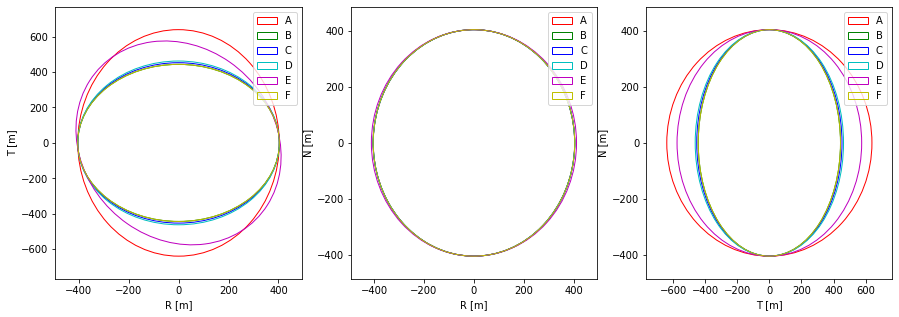

In [47]:
letters = ['A', 'B', 'C', 'D', 'E', 'F']
states = [delivery_stateA, delivery_stateB, delivery_stateC, delivery_stateD, delivery_stateE, delivery_stateF]
covars = [delivery_covA, delivery_covB, delivery_covC, delivery_covD, delivery_covE, delivery_covF]
cov_matrices = {letter:cov for letter,cov in zip(letters,covars)}
state_vectors = {letter:state for letter,state in zip(letters,states)}

plot_covariances(cov_matrices, state_vectors)

In [104]:
state_vectors['E']

array([4.37499051e+08, 5.77910164e+08, 6.97075022e+07, 8.79039347e+02,
       1.43689858e+03, 1.75328040e+02])

In [52]:
cov_matrices['A']

array([[ 4.40921319e+03,  5.17079218e+01,  2.00537029e+01,
        -3.15757468e-02,  8.66400982e-01,  2.33299291e-02,
         2.30357238e-01],
       [ 5.17079218e+01,  3.58709295e+03,  1.25625838e+00,
        -3.22879525e-03,  7.49956403e-02,  1.44827362e-03,
         1.45623736e-02],
       [ 2.00537029e+01,  1.25625838e+00,  3.58452362e+03,
        -1.26514653e-03,  2.10697721e-02,  2.12771321e-02,
         5.61705773e-03],
       [-3.15757468e-02, -3.22879525e-03, -1.26514653e-03,
         3.48186226e-06, -5.48844971e-05, -1.49764134e-06,
        -1.44867097e-05],
       [ 8.66400982e-01,  7.49956403e-02,  2.10697721e-02,
        -5.48844971e-05,  9.09600499e-04,  2.44855039e-05,
         2.41840497e-04],
       [ 2.33299291e-02,  1.44827362e-03,  2.12771321e-02,
        -1.49764134e-06,  2.44855039e-05,  1.02154713e-06,
         6.50418388e-06],
       [ 2.30357238e-01,  1.45623736e-02,  5.61705773e-03,
        -1.44867097e-05,  2.41840497e-04,  6.50418388e-06,
         7.6798630

In [50]:
len(covars)

6

In [49]:
covars[0]

array([[ 4.40921319e+03,  5.17079218e+01,  2.00537029e+01,
        -3.15757468e-02,  8.66400982e-01,  2.33299291e-02,
         2.30357238e-01],
       [ 5.17079218e+01,  3.58709295e+03,  1.25625838e+00,
        -3.22879525e-03,  7.49956403e-02,  1.44827362e-03,
         1.45623736e-02],
       [ 2.00537029e+01,  1.25625838e+00,  3.58452362e+03,
        -1.26514653e-03,  2.10697721e-02,  2.12771321e-02,
         5.61705773e-03],
       [-3.15757468e-02, -3.22879525e-03, -1.26514653e-03,
         3.48186226e-06, -5.48844971e-05, -1.49764134e-06,
        -1.44867097e-05],
       [ 8.66400982e-01,  7.49956403e-02,  2.10697721e-02,
        -5.48844971e-05,  9.09600499e-04,  2.44855039e-05,
         2.41840497e-04],
       [ 2.33299291e-02,  1.44827362e-03,  2.12771321e-02,
        -1.49764134e-06,  2.44855039e-05,  1.02154713e-06,
         6.50418388e-06],
       [ 2.30357238e-01,  1.45623736e-02,  5.61705773e-03,
        -1.44867097e-05,  2.41840497e-04,  6.50418388e-06,
         7.6798630